# Guia 4

## INTRODUCCION

En esta guia tratamos recrear el ajuste del paper de Blanton et al. (2001). Utilizando las Cadenas de Markov
Monte Carlo usando el algoritmo de Metropolis-Hastings. Con ello consegiremos de nuevo los valores obtenidos en su trabajo.

## METODO

Antes que nada, necesitamos los valores que utilizo para su trabajo. como no disponemos de dichos valores utilizando el grafico en su trabajo, obtenemos los puntos del ajuste mediante la herramienta online https://apps.automeris.io/wpd/ . A continuacion, obtenemos el mismo grafico que en su trabajo. Vamos a utilizar su modelo con los datos que nos brinda para realizar el grafico. Luego utilizaremos el likehood, los prior y las funciones de probabilidad posterior para realizar las cadenas de Markov y poder muestrear el espacio de parametros y ver si realmente es el mejor ajuste esos valores obtenidos en el paper.
Para esto separamos la cadena en dos partes, una zona llamada quemado, que es la cantidad de pasos que requiere la cadena para llegar de la condicion inicial al lugar donde la probabilidad es mas alta y una ves alli que seria la segunda parte, tomar la media de los parametros y compararlos con los valores dados. Se grafican los valores de las cadenas de un parametro en funcion de otro parametro, las cadenas y su convergencia en funcion de sus eslabones, y por ultimo, los valores de Blanton con los mas probables encontrados por este metodo.

Luego se calcula usando el metodo del gradiente descendiente el minimo de la funcion de chi cuadrado que permite establecer cual es la maxima probabilidad de likehood dadando asi la mejor eleccion de parametros por un metodo menos costoso que las cadenas de Markov. En este problema usar las cadenas es un overkill.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as st
import functools


In [2]:
puntos = pd.read_csv('puntosguia4.csv', sep=",", decimal="." , names=('x','y') )
erro_sup = pd.read_csv('errores superiores.csv', sep=",", decimal=".", names=('errx','erry') )
erro_inf = pd.read_csv('errores inferiores.csv', sep=",", decimal=".", names=('errx','erry') )

In [3]:
#Modelo
def Schechter(phi,x,alp,Mest):
    ym=0.4*np.log(10)*phi*10**(-0.4*(x-Mest)*(alp+1))*np.exp(-10**(-0.4*(x-Mest)))
    return(ym)

#probabilidad a priori
#distribuciones uniformes
#ṕor que usa los intervalos de menor o mayor?

def priorr(P,A,M,Pmin,Pmax,Amin,Amax,Mmin,Mmax):
    PRO=1.*(P < Pmax) * (P > Pmin) * (A < Amax) * (A > Amin)* (M < Mmax) * (M > Mmin)
    NORM=(Pmax-Pmin)*(Amax-Amin)*(Mmax-Mmin)#aca no falta algo?
    PRO=PRO/NORM
    return(PRO)


#asumiendo errores gausianos calculo likehood
def likehood(x,y,sigma,phi,alp,Mest):
    ym=Schechter(phi,x,alp,Mest)
#    dif=y0-y
#    a=st.norm(loc=0,scale=sigma).pdf(dif)
    a=st.norm(loc=ym,scale=sigma).pdf(y)
    like=a.prod()
    return(like)

#probabilidad posterior
def posterior(x, y, P, A, M, sigma):    
    post = likehood(x, y, sigma, P, A, M) * prior(P,A,M)
    return(post)

#establezco las variables de una exepto el x,y,z
Pmin=0.0004;Pmax=0.04;Amin=-1.9;Amax=-0.0001;Mmin=-21.9;Mmax=-19.1


prior = functools.partial(priorr,Pmin=Pmin,Pmax=Pmax,Amin=Amin,Amax=Amax,Mmin=Mmin,Mmax=Mmax)

sigma=abs((erro_sup['erry']-erro_inf['erry'])/2.0)

In [4]:
es = np.array(erro_inf['erry'])
ei = np.array(erro_sup['erry'])

es.sort()
ei.sort()

es= np.array(puntos['y'])-np.array(erro_inf['erry'])
ei= np.array(erro_sup['erry'])-np.array(puntos['y'])


#  Ajustes a los datos del modelo mediante la funcion de Schechter
$$\Phi(M) = 0.4 \cdot ln(10) \cdot \Phi^∗ \cdot 10^{ − 0.4 \cdot (M−M^∗) \cdot (\alpha + 1)} \cdot \exp ^{ 10^{ − 0.4\cdot (M−M^∗)}}$$

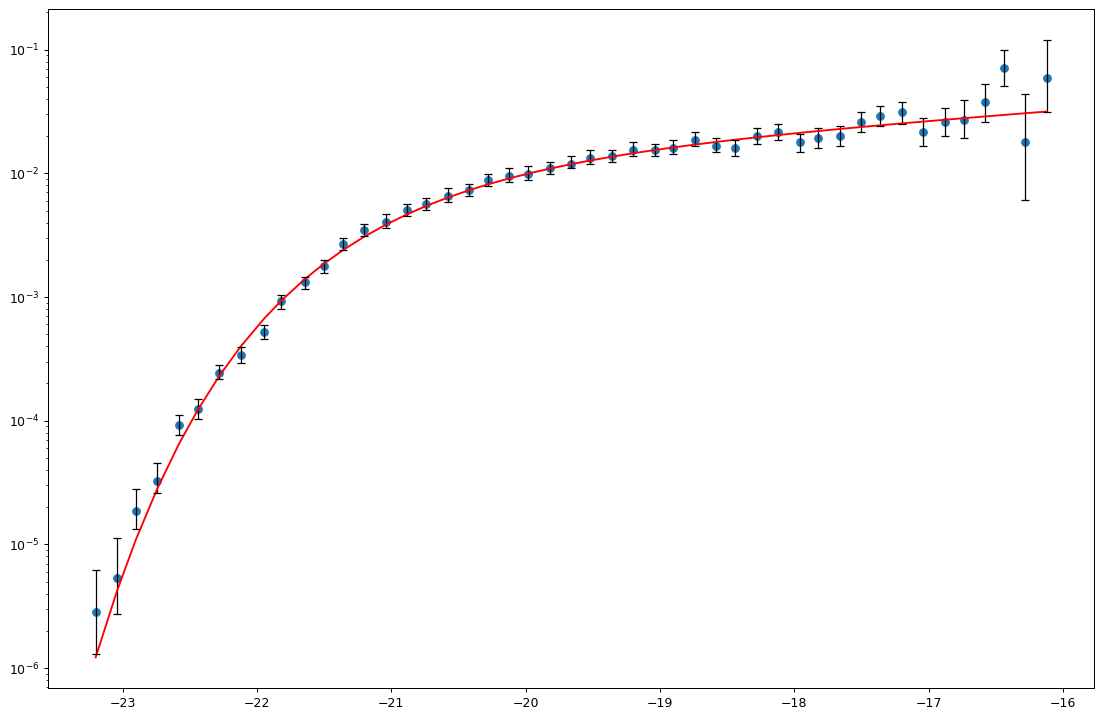

In [5]:
y=Schechter(0.0146,puntos['x'],-1.20,-20.83)
plt.figure(figsize=(15, 10), dpi=90) #dpi es la resolucion
plt.plot(puntos['x'],y,c='red')
plt.scatter(puntos['x'],puntos['y'])
#plt.scatter(puntos['x'],erro_inf['erry'],color='red')
#plt.scatter(erro_sup['errx'],erro_sup['erry'],color='red')
plt.errorbar(puntos['x'],puntos['y'],yerr=(es,ei),fmt='none',marker='o',markersize=1, color='b',ecolor='k',elinewidth=1,capsize=3,linewidth=0.5)
plt.yscale('log')




# Cadenas de Markov mediante el metodo de Metrópolis-Hastings

Ya definidas las funciones de Likehood, probabilidad posterior y prior anteriormente se utilizan para generar el algoritmo de la cadena donde buscara un punto con alguna probabilidad inicial y luego de ello saltara a algun valor cercano, evaluara el likehood y lo comparara con el anterior (cocientes de probabilidad). Esta comparacion arrojara un resultado entre 0 y 1. Para aceptar si el nuevo punto formara parte de la cadena se tira un "dado" con probabilidad uniforme entre 0 y 1 y si el cociente entre la nueva probabilidad y la anterior es mayor al valor random del dado entonces es aceptado. Caso contrario vuelvo la punto anterior y realizo otro salto aleatorio

In [6]:
likehood(puntos['x'],puntos['y'],sigma,0.0146,-1.20,-20.83)

#defino los sigmas
PhiIn=0.00002;AlpIn=0.0002;MestIn=0.002
PROPOSAL = functools.partial(np.random.multivariate_normal, cov = [[PhiIn, 0 , 0], [0, AlpIn,0], [0,0,MestIn] ] )

#defino los datos
x=puntos['x']
y=puntos['y']

In [7]:

def sorteoinicial(Pmin=Pmin,Pmax=Pmax,Amin=Amin,Amax=Amax,Mmin=Mmin,Mmax=Mmax):
    inicial=st.uniform(loc=[Pmin,Amin,Mmin], scale=[Pmax-Pmin,Amax-Amin,Mmax-Mmin])
    pin=inicial.rvs()
    phi=pin[0]
    alp=pin[1]
    mest=pin[2]
    return(phi,alp,mest)

#CADENA DE MARKOV, necesita la funcion sorteo incial
def cadenas(x,y,Npaso,sigma):
    Phicamino=[];Alpcamino=[];Mestcamino=[] 
    #en mayuscula lo nuevo, en minuscula lo viejo.
    #defino valores iniciales
    #probabilidad de donde estoy
    post=0
    i=0
    while post < 1e-4:
        phi,alp,mest=sorteoinicial()
        post=posterior(x,y, phi, alp, mest, sigma)
    inn=[phi,alp,mest]
    #calculo la cadena
    for i in range(Npaso):
        #propongo un paso
        PHI,ALP,MEST=PROPOSAL([phi,alp,mest])
        #evaluo la probabilidad ahi
        POST=posterior(x,y, PHI, ALP, MEST, sigma)
        #me fijo si es mayor o menor a donde estoy parado 
        acept = min(1., POST/post)
        #me fijo si la acepto o no
        RanAcept=np.random.rand()   
        if (acept>RanAcept):
            phi=PHI
            alp=ALP
            mest=MEST
            post=posterior(x,y, phi, alp, mest, sigma)
        #guardo las variables de cada paso
        Phicamino.append(phi)
        Alpcamino.append(alp)
        Mestcamino.append(mest)

    return(Phicamino,Alpcamino,Mestcamino,inn)

def quemado(Nquemado,Phicamino,Alpcamino,Mestcamino):
    phiafuera = Phicamino[:Nquemado]
    alpafuera = Alpcamino[:Nquemado]
    mestafuera = Mestcamino[:Nquemado]

    phidentro = Phicamino[Nquemado:]
    alpdentro = Alpcamino[Nquemado:]
    mestdentro = Mestcamino[Nquemado:]
    return(phiafuera,alpafuera,mestafuera,phidentro,alpdentro,mestdentro)

In [8]:
Phicamino,Alpcamino,Mestcamino,inn=cadenas(puntos['x'],puntos['y'],10000,sigma)
phiafuera,alpafuera,mestafuera,phidentro,alpdentro,mestdentro=quemado(2000,Phicamino,Alpcamino,Mestcamino)


In [9]:
PHI_M=np.mean(phidentro)
ALP_M=np.mean(alpdentro)
MEST_M=np.mean(mestdentro)

# Graficos de las cadenas de un parametro vs otro parametro

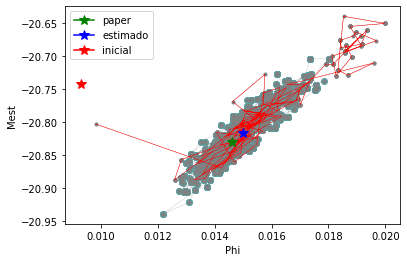

In [10]:
plt.plot(Phicamino, Mestcamino, marker='.',  lw = 0.2, color='gray')
plt.plot(phiafuera, mestafuera, marker='.', markersize=0., lw = 0.5, color='red')
plt.scatter(phidentro, mestdentro, color='cadetblue')
plt.plot(0.0146, -20.83, marker='*', markersize=10, color='g',label='paper')
plt.plot(PHI_M, MEST_M, marker='*', markersize=10, color='b',label='estimado')
plt.plot(inn[0],inn[2], marker='*', markersize=10, color='r',label='inicial')
plt.xlabel('Phi')
plt.ylabel('Mest')
plt.legend()
#plt.plot(par_a0_out, par_t0_out, marker='.', markersize=0., lw = 0.2, color='red')
#plt.scatter(par_a0_brn, par_t0_brn, color='cadetblue')

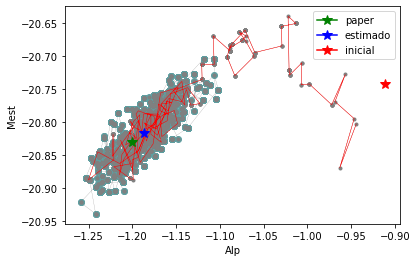

In [11]:
plt.plot(Alpcamino, Mestcamino, marker='.',  lw = 0.2, color='gray')
plt.plot(alpafuera, mestafuera, marker='.', markersize=0., lw = 0.5, color='red')
plt.scatter(alpdentro, mestdentro, color='cadetblue')

plt.plot(-1.20, -20.83, marker='*', markersize=10, color='g',label='paper')
plt.plot(ALP_M, MEST_M, marker='*', markersize=10, color='b',label='estimado')
plt.plot(inn[1],inn[2], marker='*', markersize=10, color='r',label='inicial')

plt.xlabel('Alp')
plt.ylabel('Mest')
plt.legend()

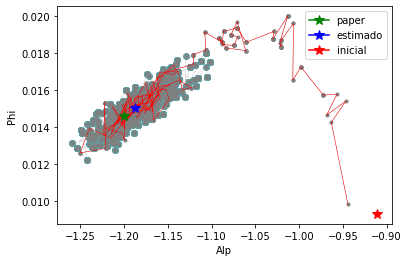

In [12]:
plt.plot(Alpcamino, Phicamino, marker='.',  lw = 0.2, color='gray')
plt.plot(alpafuera, phiafuera, marker='.', markersize=0., lw = 0.5, color='red')
plt.scatter(alpdentro, phidentro, color='cadetblue')

plt.plot(-1.20, 0.0146, marker='*', markersize=10, color='g',label='paper')
plt.plot(ALP_M, PHI_M, marker='*', markersize=10, color='b',label='estimado')
plt.plot(inn[1],inn[0], marker='*', markersize=10, color='r',label='inicial')

plt.xlabel('Alp')
plt.ylabel('Phi')
plt.legend()

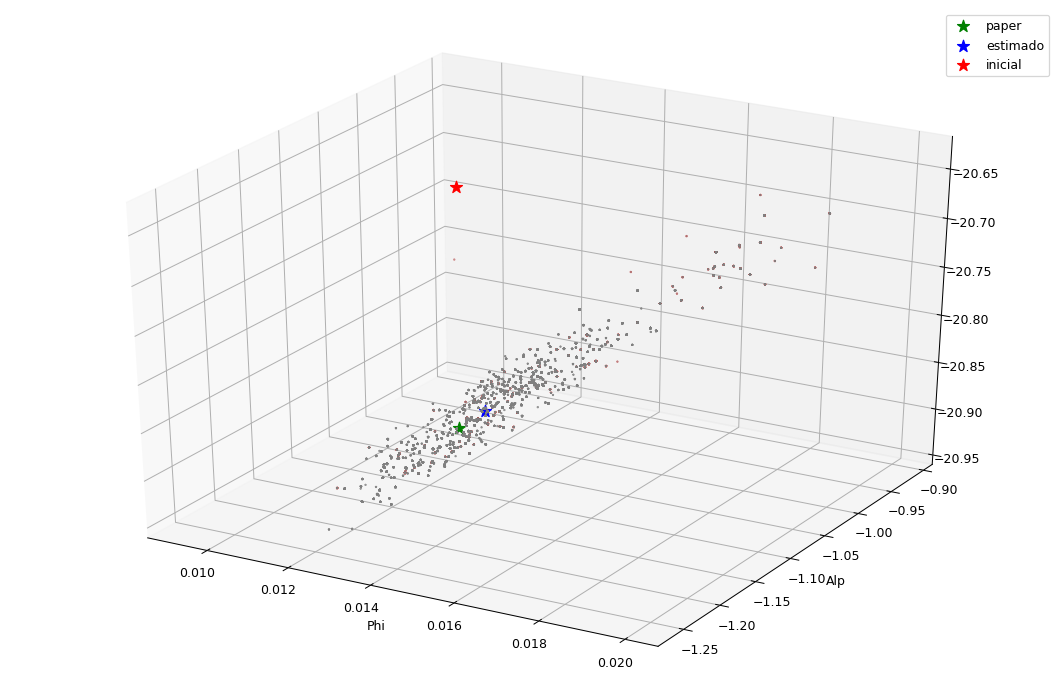

In [13]:
# importamos las librerias necesarias
from mpl_toolkits.mplot3d import axes3d

# Creamos la figura
fig = plt.figure(figsize=(15, 10), dpi=90)
# Creamos el plano 3D
ax1 = fig.add_subplot(111, projection='3d')

# Definimos los datos de prueba
x = Phicamino
y = Alpcamino
z = Mestcamino


xx = phiafuera
yy = alpafuera
zz = mestafuera

# Agregamos los puntos en el plano 3D
ax1.scatter(0.0146, -1.20, -20.83, s=100,  marker='*',zorder=5, c='GREEN',label='paper')

ax1.scatter(xx, yy, zz, s=1,  marker='*', c='red')
ax1.scatter(x, y, z, s=1,  marker='*', c='gray')

ax1.scatter(PHI_M, ALP_M, MEST_M, s=100,  marker='*',zorder=3.5, c='BLUE',label='estimado')
ax1.scatter(inn[0],inn[1],inn[2], s=100,  marker='*',zorder=2.5, c='RED',label='inicial')
plt.xlabel('Phi')
plt.ylabel('Alp')
#plt.zlabel('Mest')
ax1.legend()
plt.show()




In [14]:
#corro dos cadenas mas
Phicamino1,Alpcamino1,Mestcamino1,inn1=cadenas(puntos['x'],puntos['y'],10000,sigma)
phiafuera1,alpafuera1,mestafuera1,phidentro1,alpdentro1,mestdentro1=quemado(2000,Phicamino1,Alpcamino1,Mestcamino1)

Phicamino2,Alpcamino2,Mestcamino2,inn2=cadenas(puntos['x'],puntos['y'],10000,sigma)
phiafuera2,alpafuera2,mestafuera2,phidentro2,alpdentro2,mestdentro2=quemado(2000,Phicamino2,Alpcamino2,Mestcamino2)



In [15]:
PHIesti=np.mean(phidentro1+phidentro2+phidentro)
ALPesti=np.mean(alpdentro1+alpdentro2+alpdentro)
MESTesti=np.mean(mestdentro1+mestdentro2+mestdentro)


# Visualizacion de las cadenas y su convergencia ( Parametros vs N pasos)

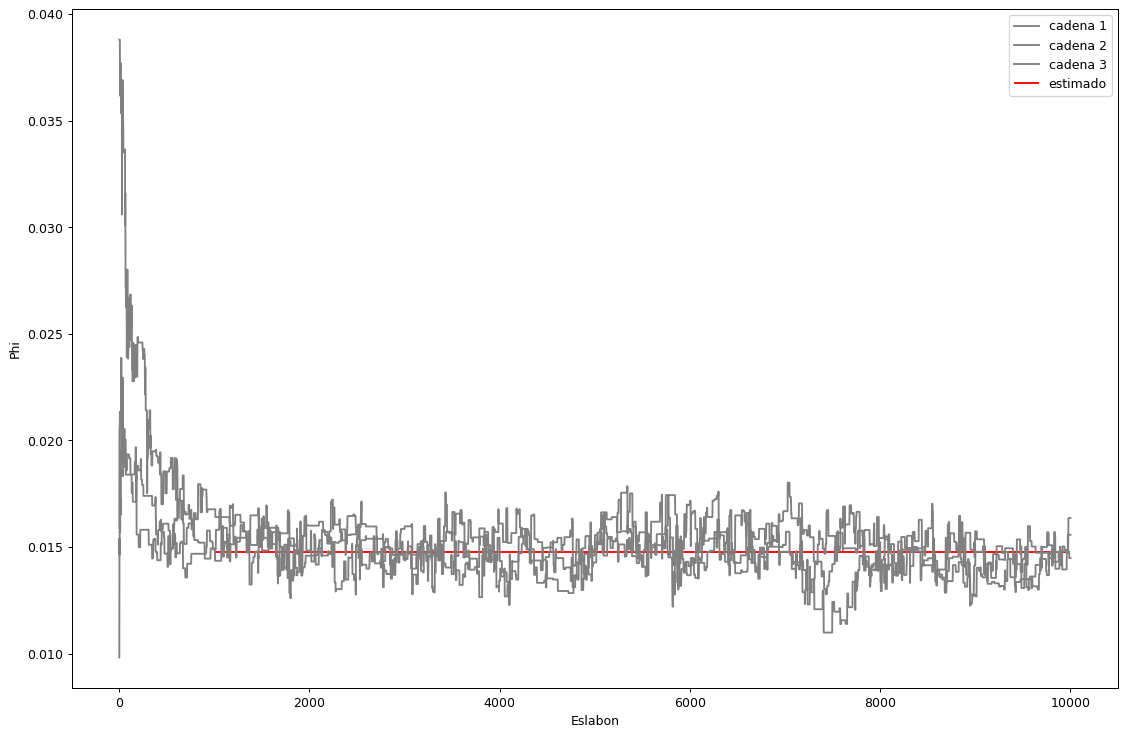

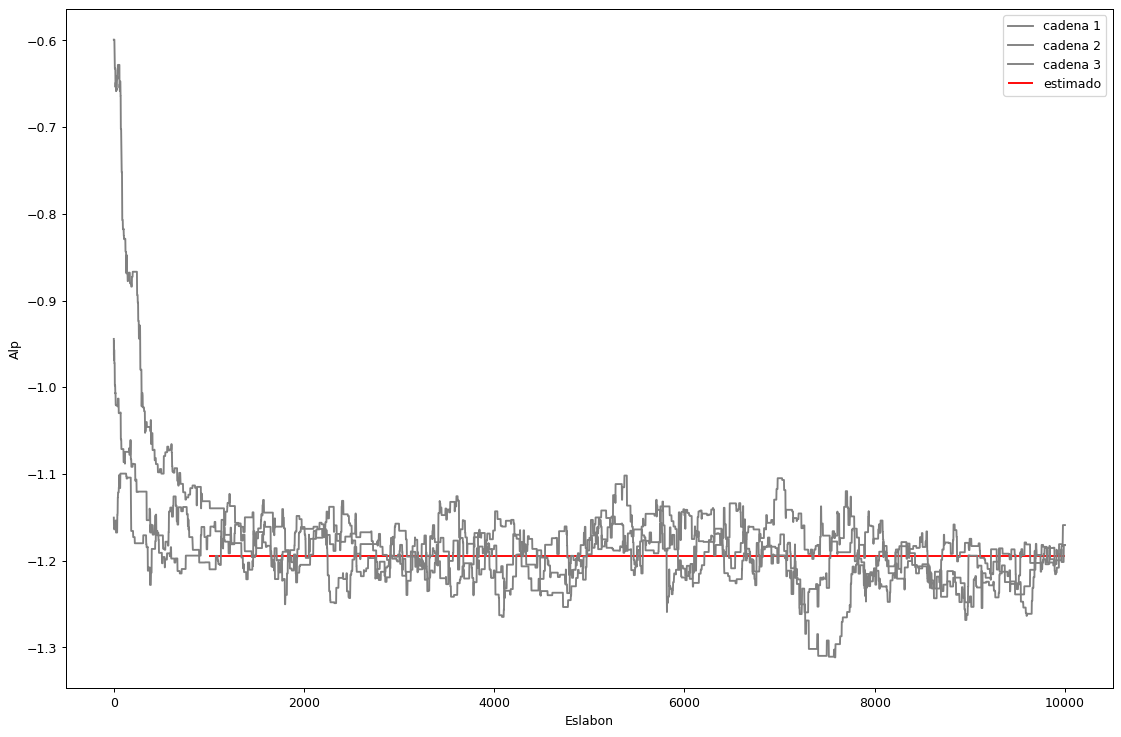

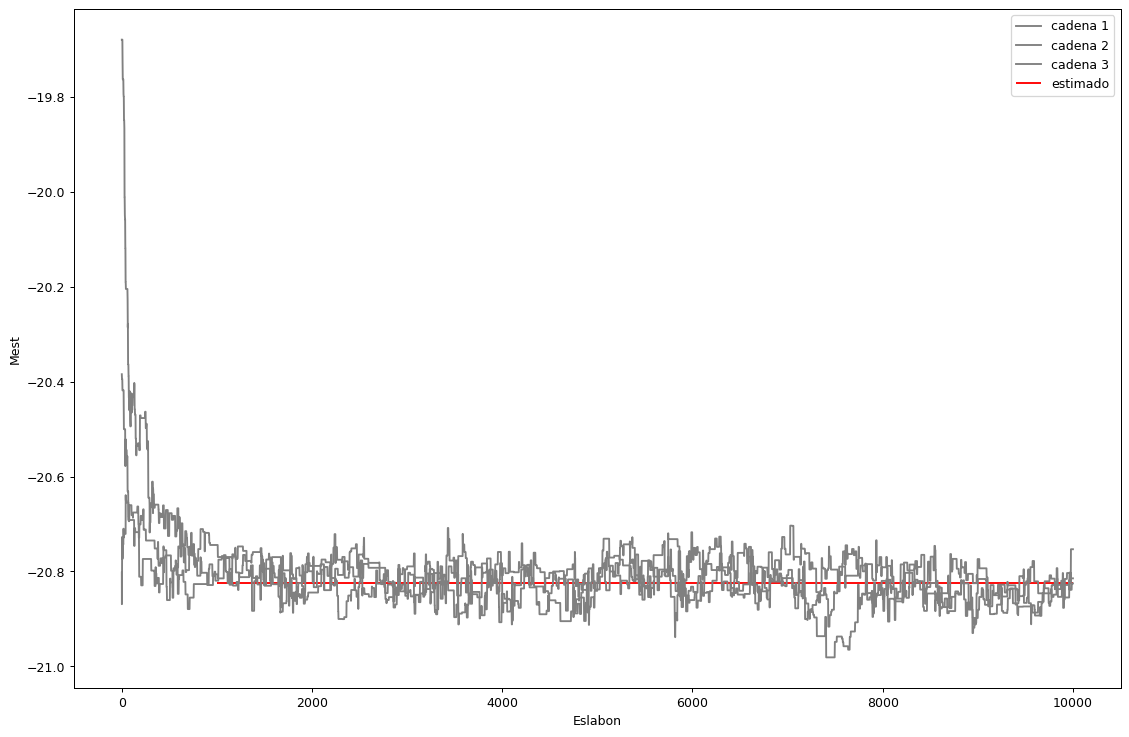

In [16]:
nn=np.linspace(1,len(Phicamino),len(Phicamino))

plt.figure(figsize=(15, 10), dpi=90)
plt.plot(nn,Phicamino,label='cadena 1',c='gray')
plt.plot(nn,Phicamino1,label='cadena 2',c='gray')
plt.plot(nn,Phicamino2,label='cadena 3',c='gray')
plt.hlines(y=PHIesti,xmin=1000,xmax=10000, colors='r',label='estimado')
plt.ylabel('Phi')
plt.xlabel('Eslabon')
plt.legend()
plt.show()

plt.figure(figsize=(15, 10), dpi=90)
plt.plot(nn,Alpcamino,label='cadena 1',c='gray')
plt.plot(nn,Alpcamino1,label='cadena 2',c='gray')
plt.plot(nn,Alpcamino2,label='cadena 3',c='gray')
plt.hlines(y=ALPesti,xmin=1000,xmax=10000, colors='r', label='estimado')
plt.ylabel('Alp')
plt.xlabel('Eslabon')
plt.legend()
plt.show()

plt.figure(figsize=(15, 10), dpi=90)
plt.ylabel('Mest')
plt.xlabel('Eslabon')
plt.plot(nn,Mestcamino,label='cadena 1',c='gray')
plt.plot(nn,Mestcamino1,label='cadena 2',c='gray')
plt.plot(nn,Mestcamino2,label='cadena 3',c='gray')
plt.hlines(y=MESTesti,xmin=1000,xmax=10000, colors='r', label='estimado')
plt.legend()
plt.show()

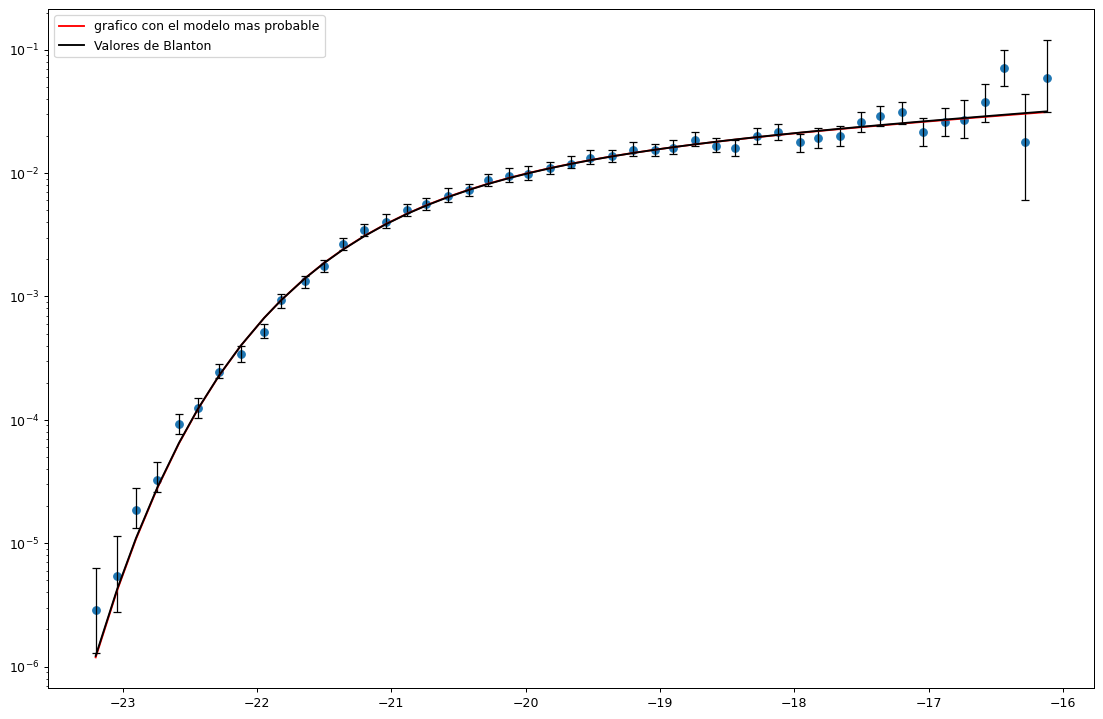

In [17]:

y=Schechter(PHIesti,puntos['x'],ALPesti,MESTesti)
plt.figure(figsize=(15, 10), dpi=90) #dpi es la resolucion
plt.plot(puntos['x'],y,c='red',label='grafico con el modelo mas probable')
plt.scatter(puntos['x'],puntos['y'])
#plt.scatter(puntos['x'],erro_inf['erry'],color='red')
#plt.scatter(erro_sup['errx'],erro_sup['erry'],color='red')
plt.errorbar(puntos['x'],puntos['y'],yerr=(es,ei),fmt='none',marker='o',markersize=1, color='b',ecolor='k',elinewidth=1,capsize=3,linewidth=0.5)

plt.plot(puntos['x'],Schechter(0.0146,puntos['x'],-1.20,-20.83),c='k',label='Valores de Blanton')
plt.yscale('log')
plt.legend()
plt.show();



# Gradiente descendiente

Vease que

$$  \nabla \chi^2 =  \nabla (
\sum_{i=1}^{N} \frac{(\Phi_{i} - \Phi(M_i))^2}{2 \cdot \sigma^2})$$
$$= - \sum_{i=1}^{N} \left(2 \cdot \frac{((\Phi_{i} - \Phi(M_i))}{2 \cdot \sigma^2}\cdot( \nabla \Phi(M_i)) \right)$$

$ \vec{GR} = \vec{(GR_{old})} - \eta  \cdot \nabla \chi^2 $

defino todas las funciones necesarias

In [34]:
sig=(erro_sup['erry']-erro_inf['erry'])
def dSchechter(phi,x,alp,Mest):
    x=np.array(x)
    dydp=Schechter(phi,x,alp,Mest)/phi
    dyda=-0.4*np.log(10)*(x-Mest)*Schechter(phi,x,alp,Mest)
    dydm= 0.4*np.log(10)*((alp+1)-10**(-0.4*(x-Mest)))*Schechter(phi,x,alp,Mest)
    return(dydp,dyda,dydm)

def chicuadrado(x,y,sigm,phi,alp,Mest):
    x=np.array(x)
    y=np.array(y)
    chi=0.0
    chi=((y-Schechter(phi,x,alp,Mest))/(sigm))**2
    chi=sum(chi)
    return (chi)

def gradiente2(x,y,phi,Mest,alp,sigma=sig):
    phi0=0
    mest0=0
    alp0=0
    sch = Schechter(phi,x,alp,Mest)
    sch = list(sch)
    sigma = list(sigma)
    x=list(x)
    y=list(y)
    dp,da,dm = dSchechter(phi,x,alp,Mest)
    dp=list(dp)
    da=list(da)
    dm=list(dm)
    for i in range(len(x)):
        phi0= phi0 - 2 * (y[i] - sch[i]) / (sigma[i]**2) * dp[i]
        mest0= mest0 - 2 * (y[i] - sch[i]) / (sigma[i]**2) * dm[i]
        alp0= alp0 - 2 * (y[i] - sch[i]) / (sigma[i]**2) * da[i]

    return(np.array([phi0, alp0, mest0]))  

In [35]:
def GraDesc(x,y,N,eta):
    #se come un eta que es una tupla de 3 componentes ordenados como [phi,alp,mest]
    
    integer  = []
    Phii  = []
    Alpp   = []
    Mestt   = []
    Grad = []

    i=0
    grad=np.array([0,0,0])
    while grad.any() < 1e-8:

        phi=np.random.uniform(0.0004, 0.025)
        mest=np.random.uniform(-21.2, -20.2) 
        alp=np.random.uniform(-1.5, -0.9)
        grad=gradiente2(x,y,phi,mest,alp,sigma=sig)         

    integer.append(i)
    Grad.append(grad)
    Phii.append(phi)
    Alpp.append(alp)
    Mestt.append(mest)

    for i in range(1,N):
        phi = phi - eta[0]*(grad[0]) 
        alp = alp - eta[1]*(grad[1]) 
        mest  = mest - eta[2]* (grad[2]) 
        grad =  gradiente2(x,y,phi,mest,alp,sigma=sig)  
            
        integer.append(i)
        Grad.append(grad)
        Phii.append(phi)
        Alpp.append(alp)
        Mestt.append(mest)
        
    return  Phii, Alpp, Mestt,integer, Grad

# Espacio de parametros y punto de Blanton

In [52]:
N=100
_Phi = np.linspace(0.0004, 0.025,N) 
_Mest = np.linspace(-21.2, -20.2,N) 
_Alp = np.linspace(-1.5, -0.9,N) 
_M1 = np.zeros((N,N))
_M2 = np.zeros((N,N))
_M3 = np.zeros((N,N))

for ix,x in enumerate(_Phi):
    for iy,y in enumerate(_Mest):
        _M1[ix,iy]=chicuadrado(puntos['x'],puntos['y'],sig,x,-1.2,y)
        

for ix,x in enumerate(_Phi):
    for iz,z in enumerate(_Alp):
        _M2[ix,iz]=chicuadrado(puntos['x'],puntos['y'],sig,x,z,-20.83)
        
        
for iy,y in enumerate(_Mest):
    for iz,z in enumerate(_Alp):
        _M3[iz,iy]=chicuadrado(puntos['x'],puntos['y'],sig,0.0146,z,y)
        

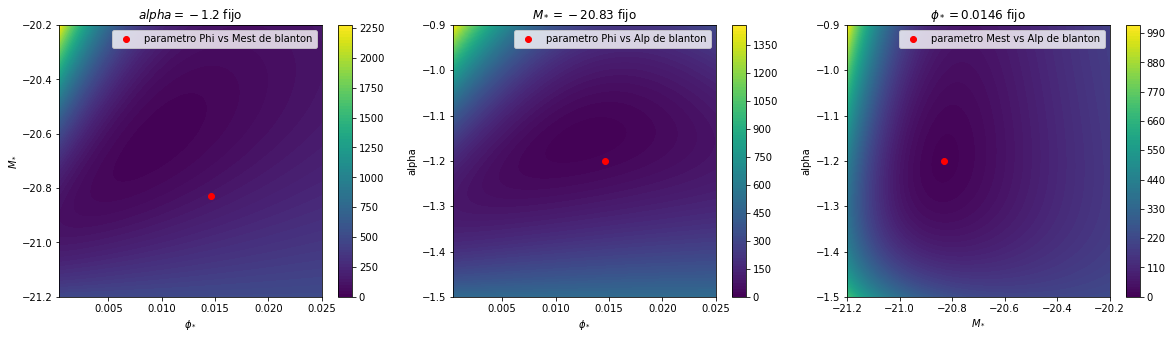

In [53]:
#parametro vs parametro
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.contourf(_Phi,_Mest,_M1,100)
plt.colorbar()
plt.plot(0.0146, -20.83, 'o', color='red', label='parametro Phi vs Mest de blanton')
plt.xlabel('$\phi_*$')
plt.ylabel('$M_*$')
plt.title('$alpha =-1.2$ fijo')
plt.legend()

plt.subplot(1,3,2)
plt.contourf(_Phi,_Alp,_M2,100)
plt.colorbar()
plt.plot(0.0146, -1.2, 'o', color='red', label='parametro Phi vs Alp de blanton')
plt.xlabel('$\phi_*$')
plt.ylabel('alpha')
plt.title('$M_*=-20.83$ fijo')
plt.legend()

plt.subplot(1,3,3)
plt.contourf(_Mest,_Alp,_M3,100)
plt.colorbar()
plt.plot(-20.83, -1.2, 'o', color='red', label='parametro Mest vs Alp de blanton')
plt.xlabel('$M_*$')
plt.ylabel('alpha')
plt.title('$\phi_*=0.0146 $ fijo')

plt.legend()
plt.show()

# Corro el gradiente descendiente

In [54]:
par=GraDesc(puntos['x'],puntos['y'],N=50,eta=[5*(10**-8),5*(10**-6),5*(10**-5)])


# Dibujo los paremetros sobre el plot

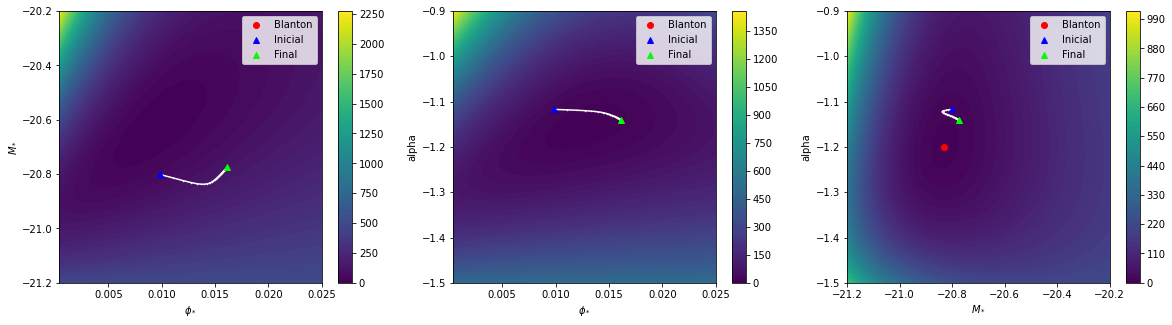

In [55]:
plt.figure(figsize=(20,5))


plt.subplot(1,3,1)
plt.contourf(_Phi,_Mest,_M1,100)
plt.colorbar()
plt.plot(0.0146, -1.2, 'o', color='red', label='Blanton')
plt.plot(par[0], par[2], marker='.',markersize=1, color='white')
plt.plot(par[0][0], par[2][0], '^', color='blue', label='Inicial') 
plt.plot(par[0][-1], par[2][-1], '^', color='lime', label='Final') 
plt.legend()
plt.xlim(0.0004,0.025)
plt.ylim(-21.2,-20.2)
plt.xlabel('$\phi_*$')
plt.ylabel('$M_*$')


plt.subplot(1,3,2)
plt.contourf(_Phi,_Alp,_M2,100)
plt.colorbar()
plt.plot(0.0146, -20.83, 'o', color='red', label='Blanton')
plt.plot(par[0], par[1], marker='.',markersize=1, color='white')
plt.plot(par[0][0], par[1][0], '^', color='blue', label='Inicial') 
plt.plot(par[0][-1], par[1][-1], '^', color='lime', label='Final') 
plt.legend()
plt.xlim(0.0004,0.025)
plt.ylim(-1.5,-0.9)

plt.xlabel('$\phi_*$')
plt.ylabel('alpha')

plt.subplot(1,3,3)
plt.contourf(_Mest,_Alp,_M3,100)
plt.colorbar()
plt.plot(-20.83, -1.2, 'o', color='red', label='Blanton')
plt.plot(par[2], par[1], marker='.',markersize=1, color='white')
plt.plot(par[2][0], par[1][0], '^', color='blue', label='Inicial') 
plt.plot(par[2][-1], par[1][-1], '^', color='lime', label='Final') 
plt.legend()
plt.xlim(-21.2,-20.2)
plt.ylim(-1.5,-0.9)
plt.xlabel('$M_*$')
plt.ylabel('alpha')

plt.show()

# 5 caminos distintos, gradientes descendientes 

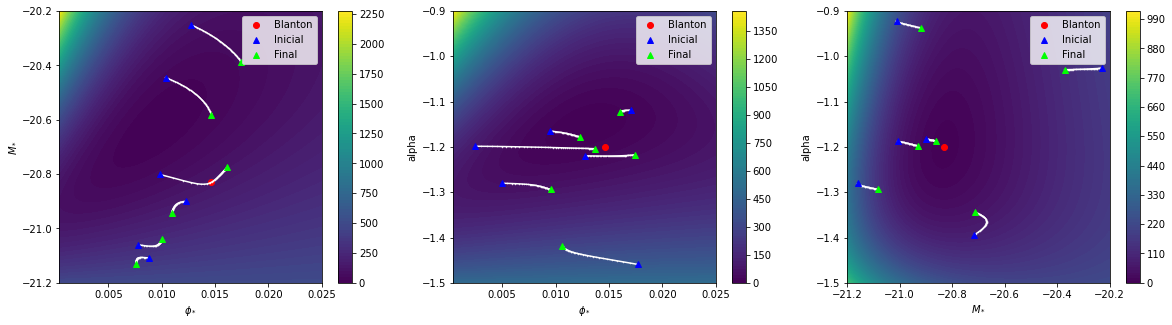

In [56]:
plt.figure(figsize=(20,5))
p=[];a=[];m=[]

plt.subplot(1,3,1)
plt.contourf(_Phi,_Mest,_M1,100)
plt.colorbar()
plt.plot(0.0146, -20.83, 'o', color='red', label='Blanton')
plt.plot(par[0], par[2], marker='.',markersize=1, color='white')
plt.plot(par[0][0], par[2][0], '^', color='blue', label='Inicial') 
plt.plot(par[0][-1], par[2][-1], '^', color='lime', label='Final') 
for par in range(5):
    par=GraDesc(puntos['x'],puntos['y'],N=50,eta=[(10**-8),(10**-6),(10**-5)])
    plt.plot(par[0], par[2], marker='.',markersize=1, color='white')
    plt.plot(par[0][0], par[2][0], '^', color='blue')
    plt.plot(par[0][-1], par[2][-1], '^', color='lime')
plt.legend()
plt.xlim(0.0004,0.025)
plt.ylim(-21.2,-20.2)
plt.xlabel('$\phi_*$')
plt.ylabel('$M_*$')

plt.subplot(1,3,2)
plt.contourf(_Phi,_Alp,_M2,100)
plt.colorbar()
plt.plot(0.0146, -1.2, 'o', color='red', label='Blanton')
plt.plot(par[0], par[1], marker='.',markersize=1, color='white')
plt.plot(par[0][0], par[1][0], '^', color='blue', label='Inicial') 
plt.plot(par[0][-1], par[1][-1], '^', color='lime', label='Final') 
for par in range(5):
    par=GraDesc(puntos['x'],puntos['y'],N=50,eta=[(10**-8),(10**-6),(10**-5)])
    plt.plot(par[0], par[1], marker='.',markersize=1, color='white')
    plt.plot(par[0][0], par[1][0], '^', color='blue')
    plt.plot(par[0][-1], par[1][-1], '^', color='lime')
    p.append(par[0][-1])
    a.append(par[1][-1])
    m.append(par[2][-1])
plt.legend()
plt.xlim(0.0004,0.025)
plt.ylim(-1.5,-0.9)
plt.xlabel('$\phi_*$')
plt.ylabel('alpha')

plt.subplot(1,3,3)
plt.contourf(_Mest,_Alp,_M3,100)
plt.colorbar()
plt.plot(-20.83, -1.2, 'o', color='red', label='Blanton')
plt.plot(par[2], par[1], marker='.',markersize=1, color='white')
plt.plot(par[2][0], par[1][0], '^', color='blue', label='Inicial') 
plt.plot(par[2][-1], par[1][-1], '^', color='lime', label='Final') 
for par in range(5):
    par=GraDesc(puntos['x'],puntos['y'],N=50,eta=[(10**-8),(10**-6),(10**-5)])
    plt.plot(par[2], par[1], marker='.',markersize=1, color='white')
    plt.plot(par[2][0], par[1][0], '^', color='blue')
    plt.plot(par[2][-1], par[1][-1], '^', color='lime')
plt.legend()
plt.xlim(-21.2,-20.2)
plt.ylim(-1.5,-0.9)
plt.xlabel('$M_*$')
plt.ylabel('alpha')

plt.show()

# Ajuste con la media dada por los 5 gradientes descendientes

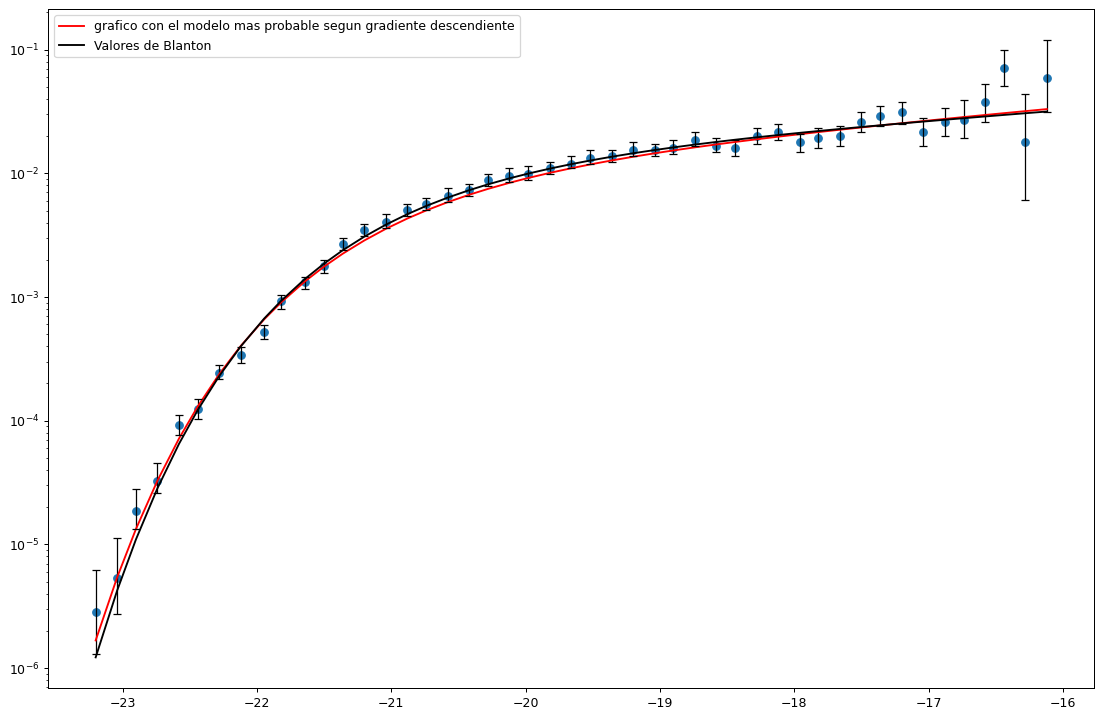

In [58]:
me=np.mean(m)
pe=np.mean(p)
ap=np.mean(a)


y=Schechter(pe,puntos['x'],ap,me)
plt.figure(figsize=(15, 10), dpi=90) #dpi es la resolucion
plt.plot(puntos['x'],y,c='red',label='grafico con el modelo mas probable segun gradiente descendiente')
plt.scatter(puntos['x'],puntos['y'])
#plt.scatter(puntos['x'],erro_inf['erry'],color='red')
#plt.scatter(erro_sup['errx'],erro_sup['erry'],color='red')
plt.errorbar(puntos['x'],puntos['y'],yerr=(es,ei),fmt='none',marker='o',markersize=1, color='b',ecolor='k',elinewidth=1,capsize=3,linewidth=0.5)

plt.plot(puntos['x'],Schechter(0.0146,puntos['x'],-1.20,-20.83),c='k',label='Valores de Blanton')
plt.yscale('log')
plt.legend()
plt.show();



# CONCLUSION

En este trabajo se usaron 3 cadenas de Markov con el metodo de Metropolis-Hastings y se pudo ver como las cadenas desde distintas condiciones iniciales entran a la misma zona, lo que nos permite inferir que no es un maximo local. Luego se comparan con los valores de Blanton con los valores mas probables obtenidos como el promedio de las tres cadenas. Posteriormente con el metodo del gradiente descendiente su busca el minimo de likehood desde distintos puntos encontrando que los mejores parametros como se puede ver en el ultimo grafico con este metodo encontrando una diferencia a los estimados por blanton pero ajusta bastante bien. Se prefiere este metodo por su simplicidad y su eficiencia sobre las cadenas de markov.